# Task sheet

In [5]:
import numpy as np
import esy.osm.pbf
from matplotlib import pyplot as plt

# Task 1: Some Statistics
a) Implement a simple system to count the number of nodes, ways and relations in your OSM file (this uses the example Andorra) and show a bar chart of the result. Remove the most frequent tag (by obvious reasons, it is not interesting)

<class 'esy.osm.pbf.file.Node'>	207322
<class 'esy.osm.pbf.file.Relation'>	245
<class 'esy.osm.pbf.file.Way'>	9671


<BarContainer object of 3 artists>

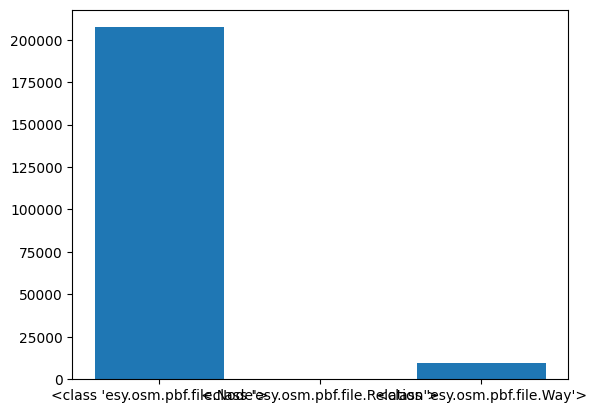

In [25]:
osm = esy.osm.pbf.File('andorra.osm.pbf')
classes = np.array([str(type(x)) for x in osm])
stats = np.unique(classes,return_counts=True)

for x,y in zip(*stats):
    print("%s\t%s"%(x,y))

plt.bar(stats[0],stats[1])


b) List all keys of nodes with their frequencies and show their relative fractions as a pie chart accumulating all keys with less than 5 elements into a class other. When you did that, the class Other is too large. Remove it as well.

{'highway': 599, 'crossing': 161, 'ele': 350, 'name': 1254, 'name:fr': 21, 'natural': 384, 'prominence': 6, 'wikidata': 141, 'wikipedia': 41, 'source': 197, 'source:date': 36, 'is_in:state': 35, 'is_in:state_code': 35, 'name:ca': 97, 'alt_name': 12, 'traffic_sign': 5, 'layer': 6, 'ref': 30, 'crossing_ref': 32, 'tourism': 280, 'direction': 16, 'mountain_pass': 33, 'foot': 23, 'barrier': 54, 'bicycle': 21, 'motorcar': 6, 'motorcycle': 6, 'waterway': 5, 'aerialway': 98, 'noexit': 11, 'is_in': 13, 'name:be': 8, 'name:be-tarask': 8, 'name:el': 10, 'name:es': 31, 'name:lt': 8, 'name:ru': 44, 'place': 122, 'website': 74, 'note': 120, 'gns:RC': 46, 'gns:UFI': 45, 'gns:UNI': 45, 'gns:ADM1': 47, 'gns:N:xx:NT': 43, 'gns:N:xx:FULL_NAME': 46, 'gns:N:xx:SORT_NAME': 44, 'gns:N:xx:FULL_NAME_ND': 47, 'gns:V:xx:NT': 12, 'gns:V:xx:FULL_NAME': 15, 'gns:V:xx:SORT_NAME': 13, 'gns:V:xx:MODIFY_DATE': 13, 'gns:V:xx:FULL_NAME_ND': 15, 'name:en': 39, 'sport': 22, 'leisure': 20, 'description': 34, 'building': 9, 

([<matplotlib.patches.Wedge at 0x20d47fb97f0>,
 [Text(1.0662754629011895, 0.2702899132687978, 'highway'),
  Text(0.9300775148759544, 0.587329393374935, 'crossing'),
  Text(0.7858348033179973, 0.7697166114188811, 'ele'),
  Text(0.14365400975278414, 1.0905794448282744, 'name'),
  Text(-0.4257909427881586, 1.0142495122205242, 'name:fr'),
  Text(-0.5892557136886304, 0.9288582797635511, 'natural'),
  Text(-0.7310612412566119, 0.8219181598750219, 'prominence'),
  Text(-0.7797494451983072, 0.7758806626749581, 'wikidata'),
  Text(-0.8360025621475695, 0.714912383500733, 'wikipedia'),
  Text(-0.9023440037964016, 0.6291067467550159, 'source'),
  Text(-0.9587974401697699, 0.5391729488057583, 'source:date'),
  Text(-0.9742460709684857, 0.5107294716407783, 'is_in:state'),
  Text(-0.988651393057923, 0.4822534841809113, 'is_in:state_code'),
  Text(-1.0135424328862987, 0.42747132855774406, 'name:ca'),
  Text(-1.0318132419551636, 0.3812629456503417, 'alt_name'),
  Text(-1.0344738907401834, 0.37398364854

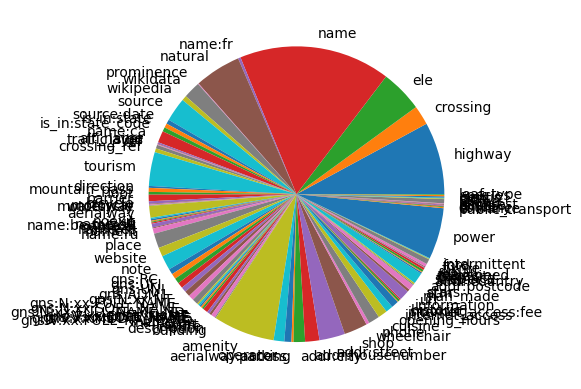

In [22]:
osm = esy.osm.pbf.File('andorra.osm.pbf')
keys = dict() # storing key, number
for x in osm:
    if type(x) == esy.osm.pbf.Node:
        for y in x.tags:
            if y not in keys:
                keys[y] = 0
            keys[y] = keys[y]+1
#print(keys)
total = np.sum([y for x,y in keys.items()])
keys = {x:y for x,y in keys.items() if y >= 5}
del keys['created_by']

subtotal = np.sum([y for x,y in keys.items()])
#keys["Other"] = int(total - subtotal)

print(keys)
plt.pie([y for x,y in keys.items()], labels=[x for x in keys])


## Task 2: Extract all highways modeled as ways using a 2-pass algorithm

In order to extract all highways, we need to first find all the ways that are highways and afterwards resolve their Nodes. We then visualize the street network. A tip for that: If you visualize it using matplotlib plot, then you can use a row of (NaN, NaN) to disconnect a line and the next one. Then, only one call to plot is sufficient for all ways.

This is a two-pass algorithm: the first pass finds all ways and, thereby, all references (refs). The second pass replaces refs with location. A way to do this (for small data) is to create a dictionary with None for each you want. Then, in the second stage, one can replace each of the Nones with longitude and latitude. This gives us access to nodes by ID. Note that this does not scale for big data.

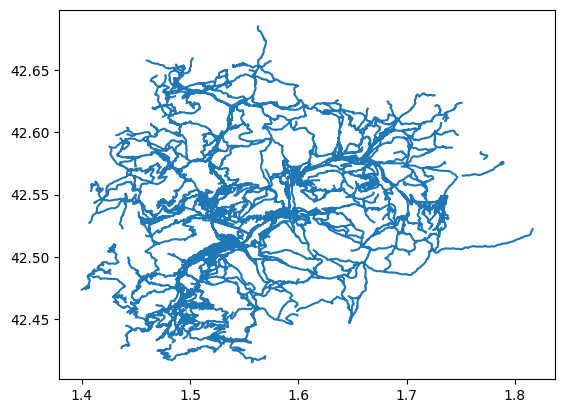

In [53]:
osm = esy.osm.pbf.File('andorra.osm.pbf')
## Pass 1: Get all highways
highways = [x for x in osm if type(x) is esy.osm.pbf.file.Way]
highways = [x for x in highways if "highway" in x.tags]
## Prepare Pass 2: Dictionary of all refs
refs = [x.refs for x in highways]
refs = [
    x
    for xs in refs
    for x in xs
]
refs = np.array(refs)
refs = np.unique(refs)
refs = {x:None for x in refs}
# Run pass 2 over file
osm = esy.osm.pbf.File('andorra.osm.pbf')
for x in osm:
    if type(x) == esy.osm.pbf.file.Node:
        if int(x.id) in refs:
            refs[int(x.id)] = [*x.lonlat]

# assemble geometry
geom = list()
for h in highways:
    for ref in h.refs:
        if int(ref) in refs and refs[int(ref)] is not None:
            geom.append(refs[int(ref)])
        else:
            print("ref %s not found" %(str(ref)))
    geom.append([np.nan,np.nan])
geom = np.array(geom)
plt.plot(geom[:,0],geom[:,1])